In [71]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
from torch import nn
from pathlib import Path
from torch.optim import Adam, AdamW, SGD
from matplotlib import pyplot as plt
from utils.plotting import plot_latent_trajectory, plot_neural_data
from data.dataset import NeuralDataset
from data.datasets.lorenz import simulate_lorenz, get_lorenz_labels, create_neural_timeseries
from utils.plotting import plot_latent_trajectory_interactive
from utils.plotting import training_summary_plot_iw

from models.layers import FactorizedEncoder, RecurrentFactorizedEncoder, AutoregressiveEncoder, PriorControlledEncoder
from models.layers import Transition, RecurrentDiscreteDecoder, GaussianLayer
from models.layers_experimental import AR1Transition
from models.vate import VATE

device = 'cuda'


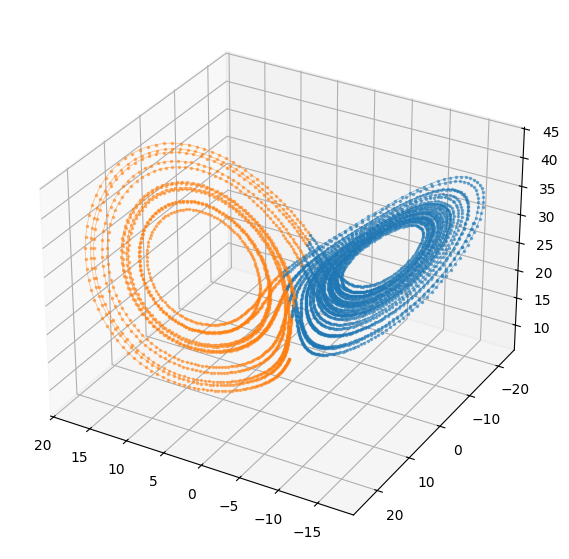

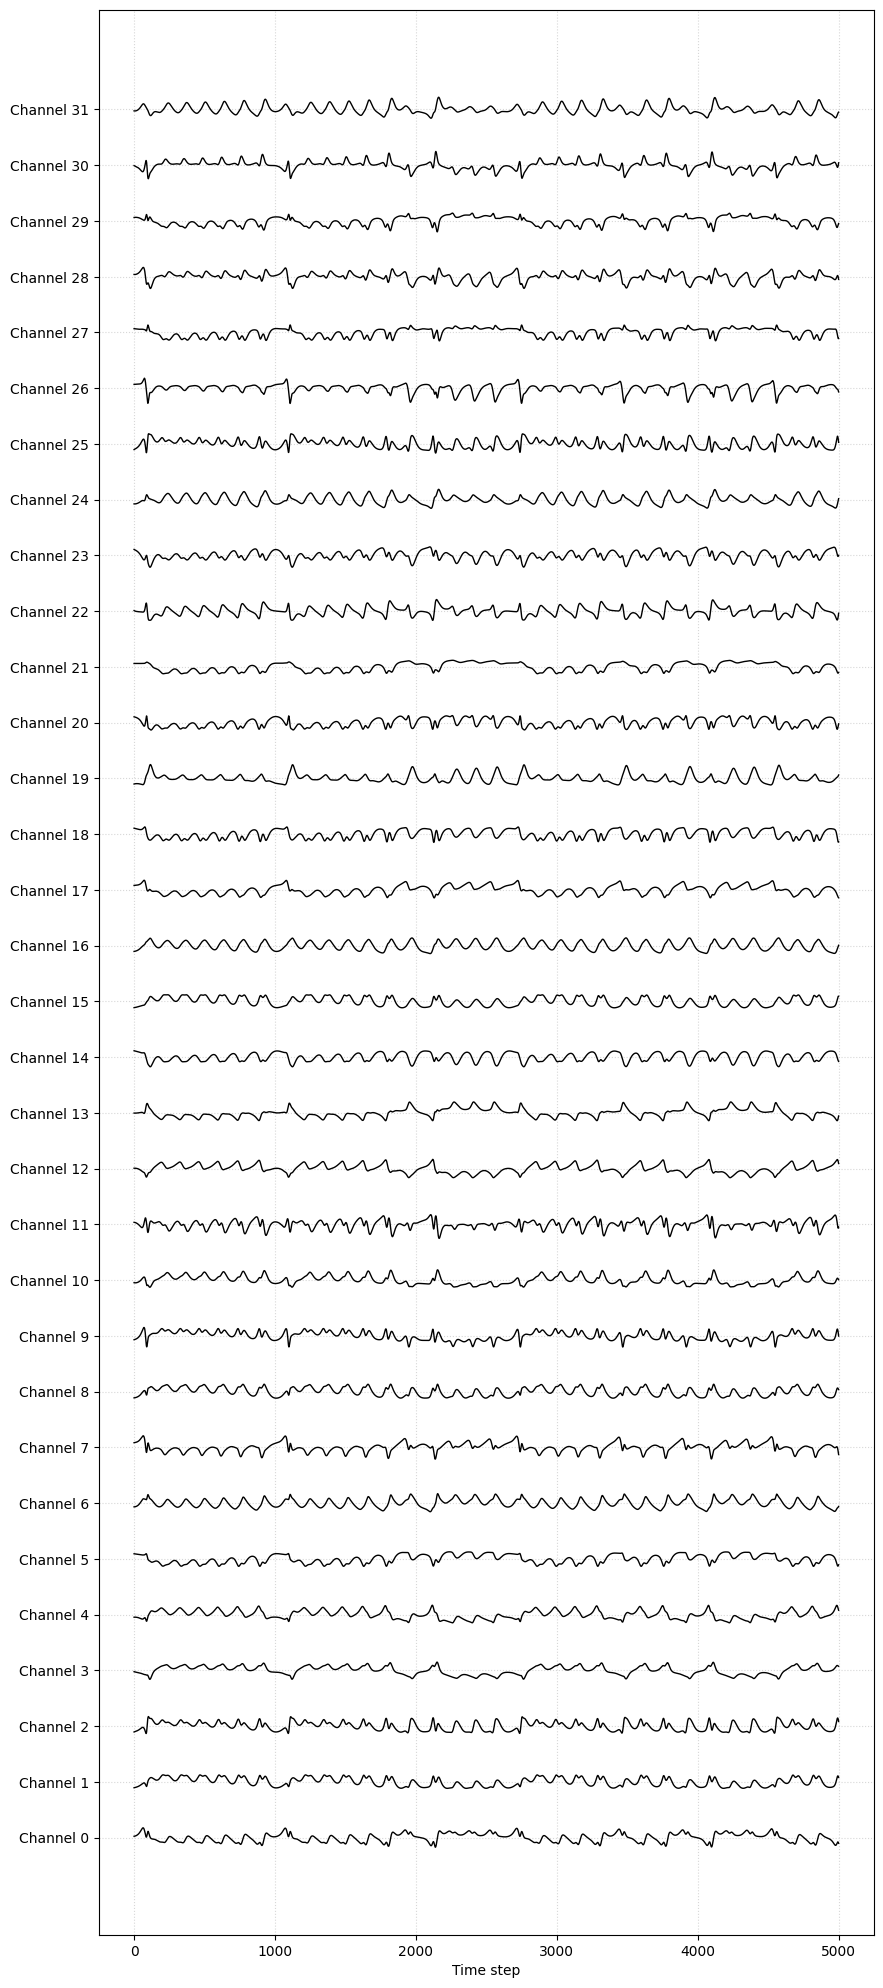

In [72]:
x0 = np.array([0,1,10])
times = np.linspace(0,25,5000)
x_lorenz = simulate_lorenz(x0, times)
labels_lorenz = get_lorenz_labels(x_lorenz)
x_neural, mapping_matrix = create_neural_timeseries(x_lorenz, channels=32)

plot_latent_trajectory(x_lorenz, labels_lorenz, markersize=3)
plot_neural_data(x_neural)

In [73]:
dataset = NeuralDataset(neural=x_neural,
                        target_labels={'behavior': labels_lorenz},
                        device=device
                        )

print(dataset)

NeuralDataset
  - Timepoints          : 5000
  - Device              : cuda
  - Dataset on device?  : True
  - Neural timeseries
	neural (continuous, shape=(5000, 32), multivariate=True)
  - Target labels timeseries
	behavior (discrete, shape=(5000, 1), multivariate=False)
  - Nuisance labels timeseries: None


In [94]:
latent_dim = 3
num_classes = 2

# encoder = FactorizedEncoder(
#     body_module=nn.Sequential(
#         nn.LazyLinear(32), nn.GELU(),
#         nn.LazyLinear(64), nn.GELU(),
#         nn.LazyLinear(128), nn.GELU(),
#     ),
#     gaussian_module=GaussianLayer(output_dim=latent_dim, fixed_logvar=-9.2)
#     )

# encoder = RecurrentFactorizedEncoder(
#     recurrent_module=nn.GRU(input_size=32, hidden_size=32, num_layers=1, batch_first=True, bidirectional=False),
#     body_module=nn.Sequential(
#         nn.LazyLinear(32), nn.GELU(),
#         nn.LazyLinear(64), nn.GELU(),
#         nn.LazyLinear(128), nn.GELU(),
#     ),
#     gaussian_module=GaussianLayer(output_dim=latent_dim, fixed_logvar=-9)
#     )

encoder = AutoregressiveEncoder(
    recurrent_module=nn.GRU(input_size=32, hidden_size=16, num_layers=1, batch_first=True, bidirectional=False),
    body_module=nn.Sequential(
        nn.LazyLinear(16), nn.GELU(),
        nn.LazyLinear(32), nn.GELU(),
        nn.LazyLinear(64), nn.GELU(),
    ),
    gaussian_module=GaussianLayer(output_dim=latent_dim),
    residual_mode='none'
    )

transition = Transition(
    body_module=nn.Sequential(
        nn.LazyLinear(64), nn.GELU(),
        nn.LazyLinear(64), nn.GELU(),
        nn.LazyLinear(64), nn.GELU(),
        nn.LazyLinear(64), nn.GELU(),

    ),   
    gaussian_module=GaussianLayer(output_dim=latent_dim),
    residual_mode='none'
    )

# encoder = PriorControlledEncoder(
#     recurrent_module=nn.GRU(input_size=32, hidden_size=16, num_layers=1, batch_first=True, bidirectional=False),
#     body_module=nn.Sequential(
#         nn.LazyLinear(16), nn.GELU(),
#         nn.LazyLinear(32), nn.GELU(),
#         nn.LazyLinear(64), nn.GELU(),
#     ),
#     transition_module=transition,
#     gaussian_module=GaussianLayer(output_dim=latent_dim)
#     )


decoder = RecurrentDiscreteDecoder(
    recurrent_module=nn.GRU(input_size=latent_dim, hidden_size=8, num_layers=1, batch_first=True, bidirectional=False),
    num_classes=num_classes
)

decoders = {'behavior': decoder}

model = VATE(encoder, transition, decoders, decode_from_posterior=True).to(device)
model.summary(input_features=32)

Module         Parameters     
------------------------------
Encoder        5766           
Transition     13126          
Decoders       
-behavior      330            
------------------------------
Total          19222          


In [95]:
# Training
optimizer = Adam(model.parameters(), lr=3e-4)
losses_history = model.fit(dataset, iterations=5000, batch_size=128,
                           window_len=30, num_particles=1,
                           variational_loss=True,
                           optimizer=optimizer)

# Training plots
plt.figure(figsize=(6,4))
plt.plot(losses_history['loss_targets_behavior'], label='Label behavior', linewidth=0.5, color='k')
plt.plot(losses_history['loss_transition'], label='Transition', linewidth=0.5, color='r')
plt.plot(losses_history['loss_prior'], label='Prior', linewidth=0.5, color='b')
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()



  0%|          | 0/5000 [00:00<?, ?it/s]

 63%|██████▎   | 3155/5000 [04:07<02:24, 12.76it/s, total_loss=0.089, loss_prior=135, loss_transition=77.8, loss_targets_behavior=0.0793] 


KeyboardInterrupt: 

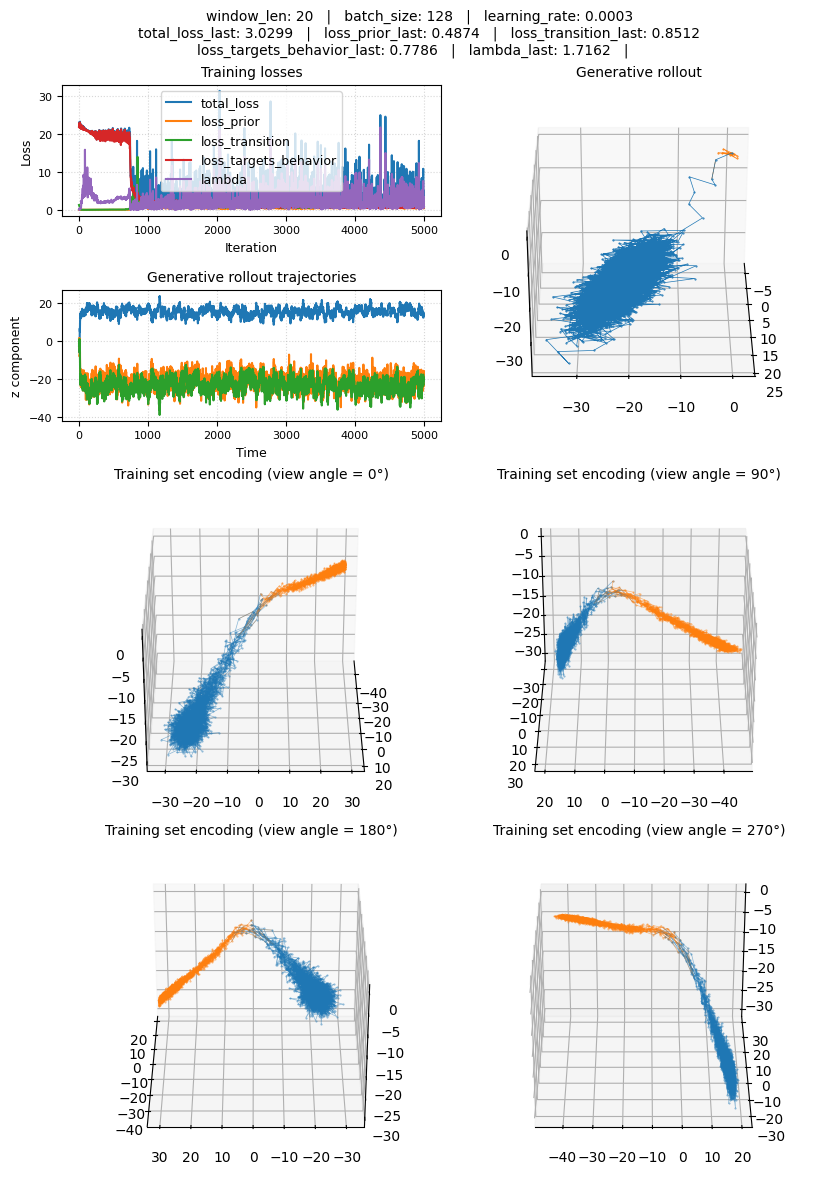

In [96]:
# Model summary plot
training_summary_plot_iw(model, dataset, losses_history, label_to_show='behavior',
                      title_args={'window_len': 20, 'batch_size': 128, 'learning_rate': 3e-4})


In [97]:
z_latent, mu_latent, _ = model.encoder(dataset.neural.data.unsqueeze(0).unsqueeze(0))
z_latent = z_latent.squeeze()
mu_latent = mu_latent.squeeze()
plot_latent_trajectory_interactive(mu_latent, labels_lorenz, markersize=2)



In [86]:
x0 = torch.FloatTensor(x_neural[0,:]).to(device)
generation_result = model.generate(x0=x0, num_steps=5000)
z_rollout, target_labels_rollout = generation_result['z_sequence'], generation_result['target_preds']
target_label_rollout_class = torch.argmax(target_labels_rollout['behavior'], axis=-1)

plot_latent_trajectory_interactive(z_rollout, target_label_rollout_class, markersize=1)




torch.Size([3000, 2])


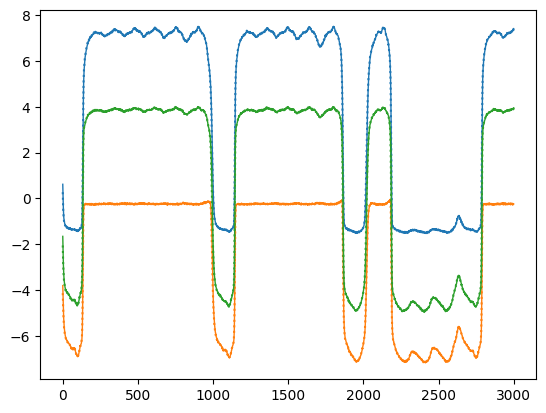

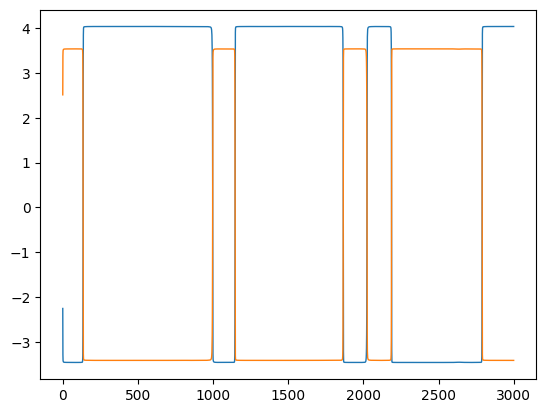

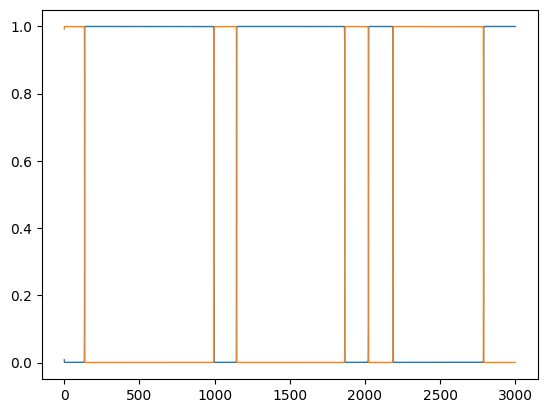

In [ ]:
x = torch.FloatTensor(x_neural[0:3000,:]).to(device)
z_enc = model.encoder(x.unsqueeze(0).unsqueeze(0))[0].squeeze()
z_trans = model.transition(z_enc.unsqueeze(0).unsqueeze(0))[0].squeeze()
y_prob = model.target_decoders['behavior'](z_enc.unsqueeze(0).unsqueeze(0)).squeeze()

print(y_prob.shape)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure()

for i in range(3):
    plt.plot(z_enc[:,i].detach().cpu().numpy(), color=colors[i], linewidth=1)
    plt.plot(z_trans[:,i].detach().cpu().numpy(), linestyle=':', color=colors[i])

plt.figure()
plt.plot(y_prob.detach().cpu().numpy(), linewidth=1)

plt.figure()
plt.plot(torch.softmax(y_prob, dim=-1).detach().cpu().numpy(), linewidth=1)


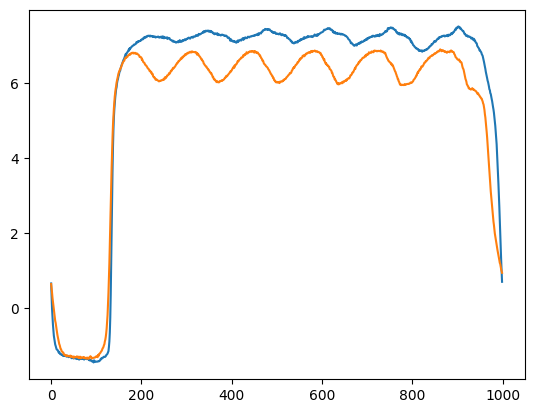

In [ ]:
# Check the difference between encoding at t=0 for all points and encoding in the autoregressive way
x = torch.FloatTensor(x_neural[0:1000,:]).to(device)
z_enc = model.encoder(x.unsqueeze(0).unsqueeze(0))[0].squeeze()

z_enc_single = []
for t in range(0, 1000):
    x = torch.FloatTensor(x_neural[t:t+1,:]).to(device)
    z_enc_single.append(model.encoder(x.unsqueeze(0).unsqueeze(0))[0].squeeze())

z_enc_single = torch.stack(z_enc_single, dim=0)

plt.figure()
plt.plot(z_enc[:, 0].detach().cpu())
# plt.figure()
plt.plot(z_enc_single[:, 0].detach().cpu())
